<a href="https://colab.research.google.com/github/DavidkingMazimpaka/NutriGuard_Mission_Capstone/blob/main/NutriGuard_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NutriGuard


---


### This AI-powered system designed for the early detection of malnutrition in children under the age of five in Western Province of Rwanda. By leveraging Rwanda Demographic Health Survey (DHS) data from the 2021 report and UNICEF Data and Ntaganzwa Healthcentre Data, This Notebook Unsupervised and Supervised to train the different models.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. K-Means Clustering (Unsupervised Technique) with RDHS Data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
data_path = '/content/drive/MyDrive/ALU Final year ML/NutriGuard Mission Capstone/combined_dataset.csv'
data = pd.read_csv(data_path)

# Preview the dataset
data.head()
data.columns

Index(['Background Characteristic', 'Height-for-age (% below -3 SD)',
       'Height-for-age (% below -2 SD)', 'Height-for-age (Mean Z-score)',
       'Height-for-age (Number of children)',
       'Weight-for-height (% below -3 SD)',
       'Weight-for-height (% below -2 SD)', 'Weight-for-height (% above 2 SD)',
       'Weight-for-height (Mean Z-score)',
       'Weight-for-height (Number of children)',
       'Weight-for-age (% below -3 SD)', 'Weight-for-age (% below -2 SD)',
       'Weight-for-age (% above 2 SD)', 'Weight-for-age (Mean Z-score)',
       'Weight-for-age (Number of children)'],
      dtype='object')

In [5]:
# Select relevant features for clustering
features = data[['Height-for-age (Mean Z-score)', 'Weight-for-age (Mean Z-score)']]  # Adjust based on your dataset

In [6]:
# Step 1: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


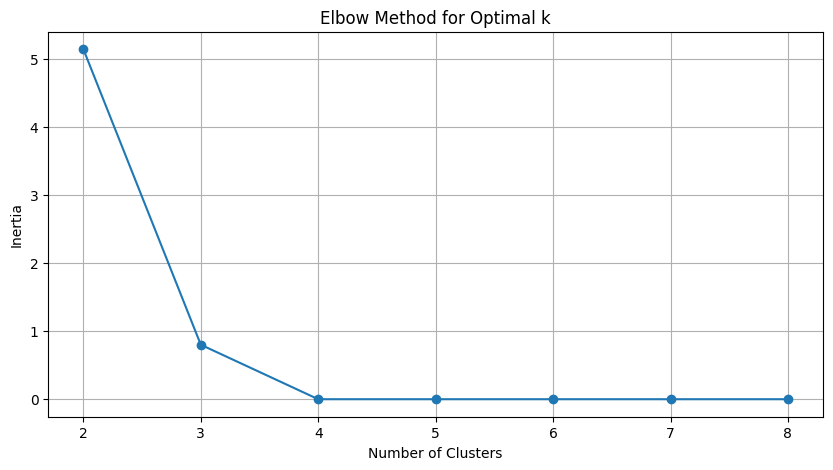

In [7]:
# Step 2: Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []

# Change the range of k to be less than or equal to the number of samples
for k in range(2, min(11, features_scaled.shape[0] + 1)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, min(11, features_scaled.shape[0] + 1)), inertia, marker='o')  # Adjust x-axis range
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [8]:
# Step 3: Fit the K-Means model with the optimal number of clusters (e.g., 3)
optimal_k = 3  # Choose based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

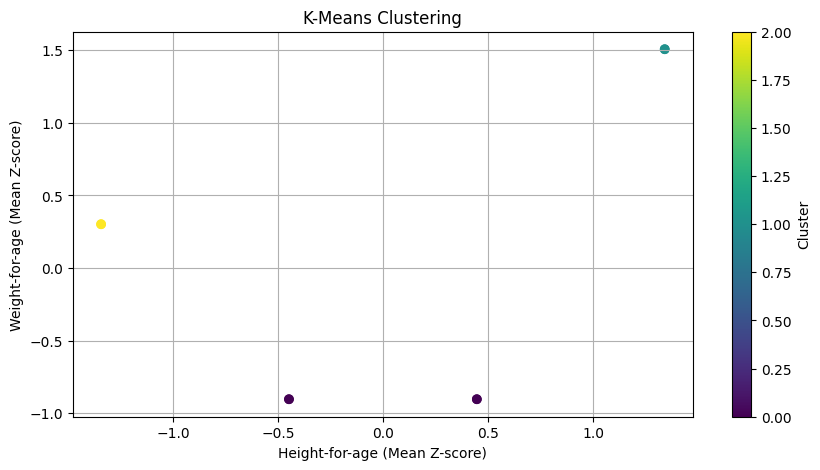

In [9]:
# Step 4: Visualize the clusters (if 2D features)
plt.figure(figsize=(10, 5))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=data['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Height-for-age (Mean Z-score)')
plt.ylabel('Weight-for-age (Mean Z-score)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [10]:
# Check the cluster assignments
print(data[['Height-for-age (Mean Z-score)', 'Weight-for-age (Mean Z-score)', 'Cluster']].head())

   Height-for-age (Mean Z-score)  Weight-for-age (Mean Z-score)  Cluster
0                           -1.2                           -0.4        1
1                           -1.3                           -0.6        0
2                           -1.4                           -0.6        0
3                           -1.5                           -0.5        2
4                           -1.2                           -0.4        1


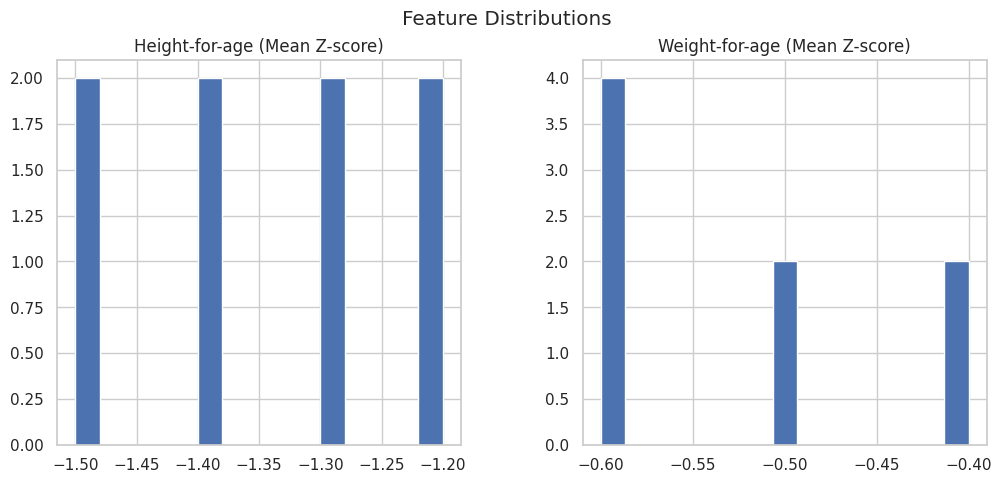

In [11]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot histograms for each feature
features = ['Height-for-age (Mean Z-score)', 'Weight-for-age (Mean Z-score)']  # Adjust as needed
data[features].hist(bins=15, figsize=(12, 5), layout=(1, 2))
plt.suptitle('Feature Distributions')
plt.show()

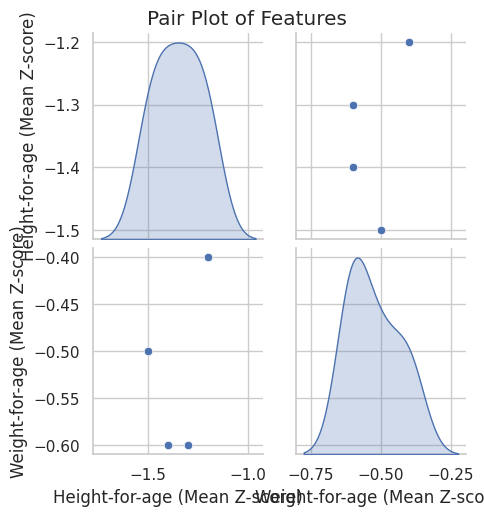

In [12]:
# Pair plot
sns.pairplot(data[features], diag_kind='kde')
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

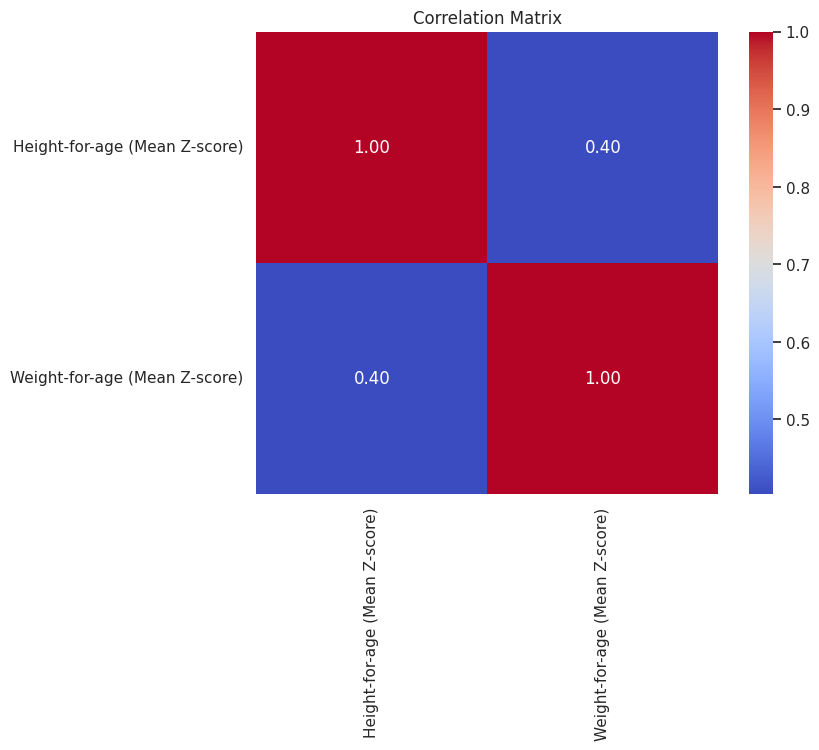

In [13]:
# Calculate the correlation matrix
correlation_matrix = data[features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Implementing Random Forest, Logistic Regression, and Extreme Gradient Boosting (XGBoost) as Supervised Learning Algorithms with Ntaganzwa Health centre Data.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [15]:
dataSet = pd.read_csv('/content/drive/MyDrive/ALU Final year ML/NutriGuard Mission Capstone/Malnutrition data.csv')
df = dataSet
dataSet.head()


,Sex,Age,Height,Weight,Low Income,Lower Middle Income,Upper Middle Income,Status
0,1,5,75,17,1,0,0,Stunting
1,0,4,101,13,1,0,0,Stunting
2,0,4,71,17,1,0,0,Stunting
3,0,3,81,13,0,0,1,Stunting
4,0,1,79,16,0,0,1,Stunting


In [16]:
# Dealing with categorical Data
from google.colab import sheets
df['Sex'].value_counts()

,count
Sex,
1,421
0,416


In [17]:
df['Status'].value_counts()

,count
Status,
Stunting,696
Overweight,94
Underweight,43
Wasting,4


In [18]:
df.describe()

,Sex,Age,Height,Weight,Low Income,Lower Middle Income,Upper Middle Income
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,0.502987,2.947431,88.559140,14.463560,0.227001,0.397849,0.291517
std,0.500290,1.406447,10.821536,3.457559,0.419144,0.489747,0.454733
min,0.000000,1.000000,70.000000,9.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,80.000000,11.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,89.000000,15.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,98.000000,17.000000,0.000000,1.000000,1.000000
max,1.000000,5.000000,107.000000,20.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Low Income'}>,
        <Axes: title={'center': 'Lower Middle Income'}>],
       [<Axes: title={'center': 'Upper Middle Income'}>, <Axes: >,
        <Axes: >]], dtype=object)

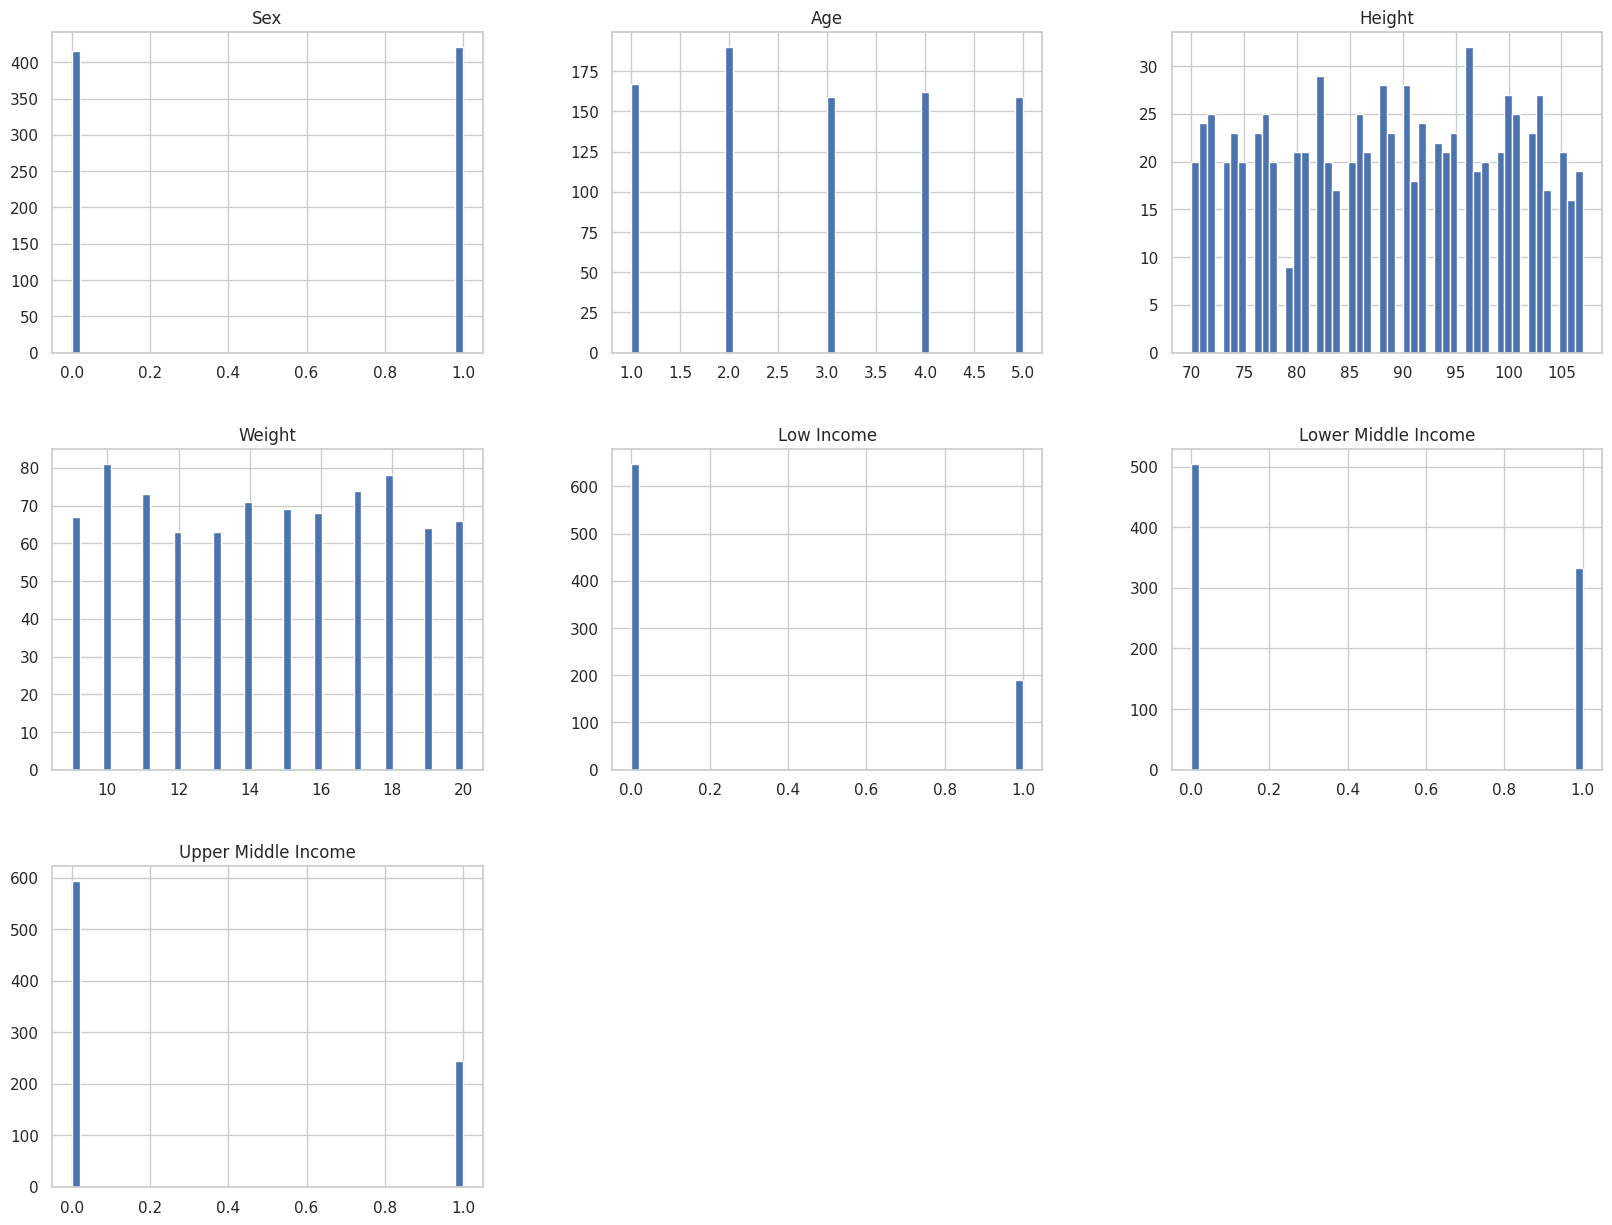

In [19]:
df.hist(bins=50, figsize=(20,15))

### Visualising informaiton about the Status column which is categorical data


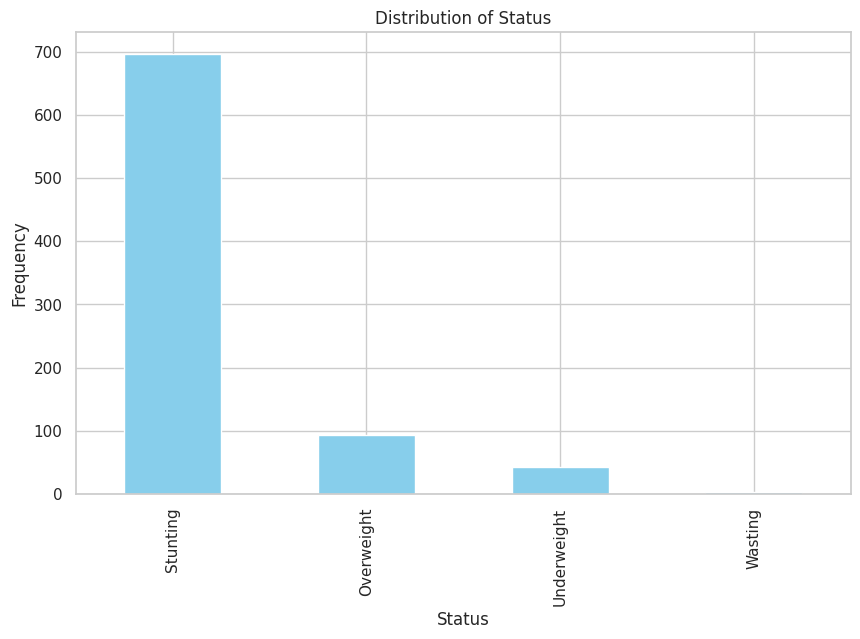

In [20]:
df['Status'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.title('Distribution of Status')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.show()

In [21]:
df.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Low Income', 'Lower Middle Income',
       'Upper Middle Income', 'Status'],
      dtype='object')

In [22]:
# Removing unnecessary columns
df = df.drop('Low Income '.strip(), axis=1)
df = df.drop('Lower Middle Income '.strip(), axis=1)
df = df.drop('Upper Middle Income '.strip(), axis=1)

In [23]:
df.describe()

,Sex,Age,Height,Weight
count,837.000000,837.000000,837.000000,837.000000
mean,0.502987,2.947431,88.559140,14.463560
std,0.500290,1.406447,10.821536,3.457559
min,0.000000,1.000000,70.000000,9.000000
25%,0.000000,2.000000,80.000000,11.000000
50%,1.000000,3.000000,89.000000,15.000000
75%,1.000000,4.000000,98.000000,17.000000
max,1.000000,5.000000,107.000000,20.000000


In [24]:
# Separating the labels and features
X = df.drop("Status", axis=1)  # Features
y = df["Status"]  # Labels

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>]], dtype=object)

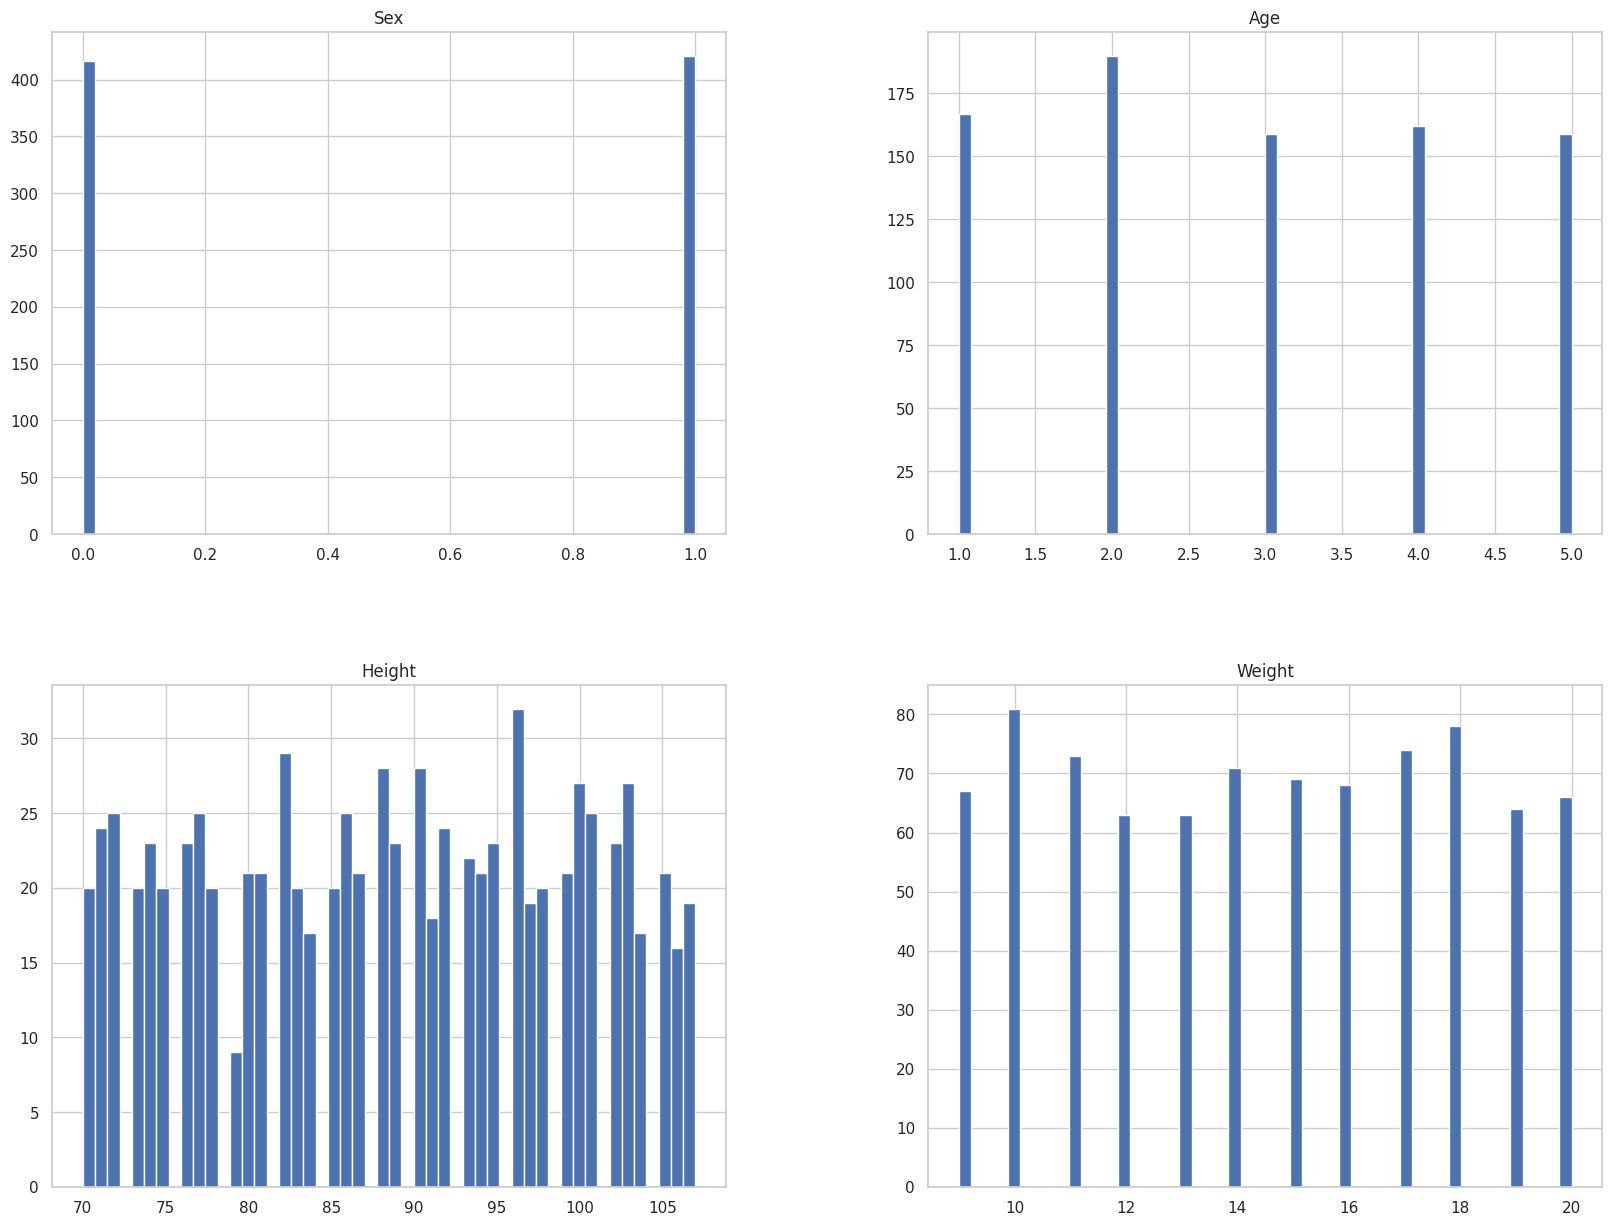

In [25]:
# Visualising the interger type data using a histogram

df.hist(bins=50, figsize=(20,15))

### Splitting the Dataset into training and Testing and Validation

In [40]:
# Libraries necessary for training
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the 'temp' sets into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (585, 4) (585,)
Validation set: (126, 4) (126,)
Testing set: (126, 4) (126,)


### Training the model with RF-Classifier

In [29]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred) * 100))

# Predictions on the temporary set
y_temp_pred = model.predict(X_temp)

# Evaluate the model on the temporary set
print("\nTemporary Set:")
print(confusion_matrix(y_temp, y_temp_pred))
print(classification_report(y_temp, y_temp_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_temp, y_temp_pred) * 100))

Validation Set:
[[  2   7   1   0]
 [  5 102   3   0]
 [  1   4   0   0]
 [  0   1   0   0]]
              precision    recall  f1-score   support

  Overweight       0.25      0.20      0.22        10
    Stunting       0.89      0.93      0.91       110
 Underweight       0.00      0.00      0.00         5
     Wasting       0.00      0.00      0.00         1

    accuracy                           0.83       126
   macro avg       0.29      0.28      0.28       126
weighted avg       0.80      0.83      0.81       126

Accuracy: 82.54%

Temporary Set:
[[  2  25   1   0]
 [  9 194   8   0]
 [  2  10   0   0]
 [  0   1   0   0]]
              precision    recall  f1-score   support

  Overweight       0.15      0.07      0.10        28
    Stunting       0.84      0.92      0.88       211
 Underweight       0.00      0.00      0.00        12
     Wasting       0.00      0.00      0.00         1

    accuracy                           0.78       252
   macro avg       0.25      0.25   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [30]:
# Train the model on the training set
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = model.predict(X_val)

# Print the predicted labels and compare with the actual labels
print("Predicted Labels:", y_val_pred)
print("Actual Labels   :", y_val.tolist())  # Convert y_val to a list for easy comparison

# Evaluate the model on the validation set
print("Validation Set:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred) * 100))

Predicted Labels: ['Stunting' 'Stunting' 'Overweight' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Overweight' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Underweight' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Underweight' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Overweight' 'Overweight'
 'Stunting' 'Stunting' 'Stunting' 'Underweight' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Overweight'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Underweight' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Underweight'
 'Stunting' 'Stunti

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
#model.fit(X_train, y_train)
temp = pd.DataFrame(model.predict_proba(X_train).tolist(), columns=model.classes_)
temp

,Overweight,Stunting,Underweight,Wasting
0,0.000000,0.996667,0.003333,0.0
1,0.000000,0.983333,0.016667,0.0
2,0.103333,0.896667,0.000000,0.0
3,0.026667,0.936667,0.036667,0.0
4,0.003333,0.996667,0.000000,0.0
...,...,...,...,...
580,0.000000,0.806667,0.193333,0.0
581,0.050000,0.950000,0.000000,0.0
582,0.020000,0.973333,0.006667,0.0
583,0.053333,0.946667,0.000000,0.0


In [34]:
# Returning Max-Probability to assign and adjust the Threshold

temp['max_prob'] = temp.max(axis=1)
temp

,Overweight,Stunting,Underweight,Wasting,max_prob
0,0.000000,0.996667,0.003333,0.0,0.996667
1,0.000000,0.983333,0.016667,0.0,0.983333
2,0.103333,0.896667,0.000000,0.0,0.896667
3,0.026667,0.936667,0.036667,0.0,0.936667
4,0.003333,0.996667,0.000000,0.0,0.996667
...,...,...,...,...,...
580,0.000000,0.806667,0.193333,0.0,0.806667
581,0.050000,0.950000,0.000000,0.0,0.950000
582,0.020000,0.973333,0.006667,0.0,0.973333
583,0.053333,0.946667,0.000000,0.0,0.946667


In [36]:
idx = temp[temp.max_prob >= 0.85].index

In [39]:
# Train the model on the training set
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train)

# Predictions on the test set
y_test_pred = model.predict(X_test)

# Print the predicted labels and compare with the actual labels
print("Predicted Labels (Test Set):", y_test_pred)
print("Actual Labels (Test Set)   :", y_test.tolist())  # Convert y_test to a list for easy comparison

# Evaluate the model on the test set
print("\nTest Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))

Predicted Labels (Test Set): ['Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Overweight' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Overweight' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Overweight' 'Stunting' 'Underweight'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Underweight'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Overweight' 'Stunting' 'Stunting' 'Underweight' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting' 'Stunting'
 'Stunting' 'Stunting' 'Stunting' 'Overweight' 'Stunting' 'Stunting'
 'Stunting' 'S

In [41]:
# Assuming X contains the features and y contains the labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the 'temp' sets into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can adjust the kernel and other parameters based on your data

# Train the SVM model on the training set
svm_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = svm_model.predict(X_val)

# Evaluate the SVM model on the validation set
print("Validation Set:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred) * 100))

# Predictions on the test set
y_test_pred = svm_model.predict(X_test)

# Evaluate the SVM model on the test set
print("\nTest Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))

Validation Set:
[[  0  10   0   0]
 [  0 110   0   0]
 [  0   5   0   0]
 [  0   1   0   0]]
              precision    recall  f1-score   support

  Overweight       0.00      0.00      0.00        10
    Stunting       0.87      1.00      0.93       110
 Underweight       0.00      0.00      0.00         5
     Wasting       0.00      0.00      0.00         1

    accuracy                           0.87       126
   macro avg       0.22      0.25      0.23       126
weighted avg       0.76      0.87      0.81       126

Accuracy: 87.30%

Test Set:
[[  0  18   0]
 [  0 101   0]
 [  0   7   0]]
              precision    recall  f1-score   support

  Overweight       0.00      0.00      0.00        18
    Stunting       0.80      1.00      0.89       101
 Underweight       0.00      0.00      0.00         7

    accuracy                           0.80       126
   macro avg       0.27      0.33      0.30       126
weighted avg       0.64      0.80      0.71       126

Accuracy: 80.16%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [50]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/ALU Final year ML/NutriGuard Mission Capstone/Malnutrition data.csv')

# Encode categorical variable 'Sex' using one-hot encoding
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

# Convert 'Status' column to numerical values using label encoding
label_encoder = LabelEncoder()
data['Status'] = label_encoder.fit_transform(data['Status'])

# Split the dataset into features (X) and target variable (y)
X = data.drop('Status', axis=1)
y = data['Status']

# Convert all columns in X to numeric, coerce errors to NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Impute NaN values with the mean of the column
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_temp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to TensorFlow tensors explicitly
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Reshape labels for binary classification
y_train = tf.reshape(y_train, [-1, 1])
y_val = tf.reshape(y_val, [-1, 1])
y_test = tf.reshape(y_test, [-1, 1])

# Build a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network on the training set
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Predictions on the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Convert back to numpy for sklearn metrics
y_val = y_val.numpy().flatten()

# Evaluate the model on the validation set
print("\nValidation Set:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred) * 100))

# Predictions on the test set
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Convert back to numpy for sklearn metrics
y_test = y_test.numpy().flatten()

# Evaluate the model on the test set
print("\nTest Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4449 - loss: 0.7241 - val_accuracy: 0.8730 - val_loss: 0.4295
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8386 - loss: 0.3803 - val_accuracy: 0.8730 - val_loss: 0.2178
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8222 - loss: 0.2592 - val_accuracy: 0.8730 - val_loss: 0.1281
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8215 - loss: 0.1380 - val_accuracy: 0.8730 - val_loss: 0.0911
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8351 - loss: 0.1358 - val_accuracy: 0.8730 - val_loss: 0.0803
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8219 - loss: 0.1337 - val_accuracy: 0.8730 - val_loss: 0.0737
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8301 - loss: 0.1303 - val_accuracy: 0.8730 - val_loss: 0.0656
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8341 - loss: 0.0151 - val_accuracy: 0.8730 - val_loss: 0.0522
Ep

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Validation Set:
[[  3   7   0   0]
 [  5 105   0   0]
 [  0   5   0   0]
 [  0   1   0   0]]
              precision    recall  f1-score   support

         0.0       0.38      0.30      0.33        10
         1.0       0.89      0.95      0.92       110
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         1

    accuracy                           0.86       126
   macro avg       0.32      0.31      0.31       126
weighted avg       0.81      0.86      0.83       126

Accuracy: 85.71%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Test Set:
[[ 6 12  0]
 [ 4 97  0]
 [ 0  7  0]]
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43        18
         1.0       0.84      0.96      0.89       101
         2.0       0.00      0.00      0.00         7

    accuracy                           0.82       126
   macro avg       0.48      0.43      0.44       126
weig

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

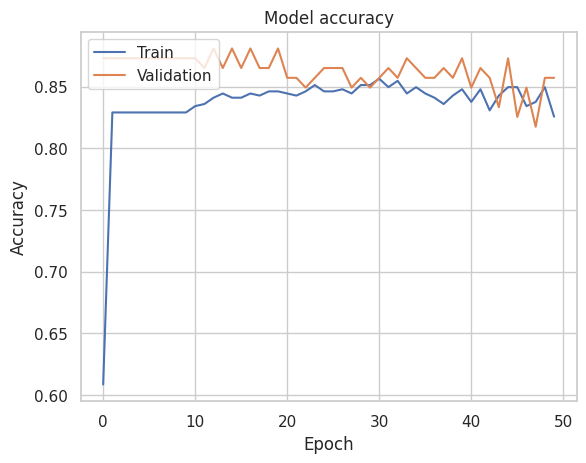

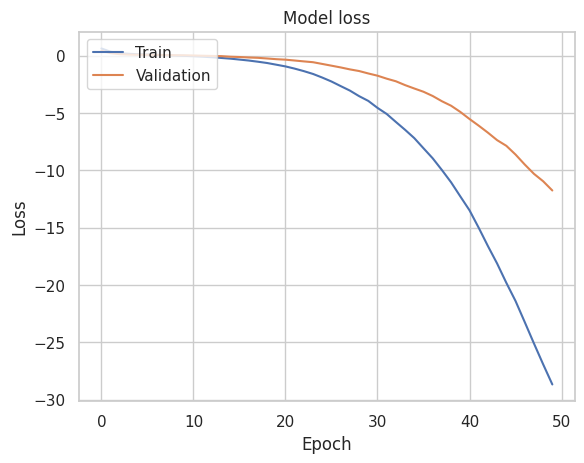

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Encoding nun-numeric values to numeric using SVM Algorithm

In [52]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming X contains your features and y contains your labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the 'temp' sets into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encode non-numeric labels in y_train using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the SVM model on the training set
svm_model.fit(X_train, y_train_encoded)

# Encode non-numeric labels in y_val and y_test
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Predictions on the validation set
y_val_pred = svm_model.predict(X_val)

# Evaluate the SVM model on the validation set
print("Validation Set:")
print(confusion_matrix(y_val_encoded, y_val_pred))
print(classification_report(y_val_encoded, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val_encoded, y_val_pred) * 100))

# Predictions on the test set
y_test_pred = svm_model.predict(X_test)

# Evaluate the SVM model on the test set
print("\nTest Set:")
print(confusion_matrix(y_test_encoded, y_test_pred))
print(classification_report(y_test_encoded, y_test_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_encoded, y_test_pred) * 100))

Validation Set:
[[  6   4   0   0]
 [  1 109   0   0]
 [  0   5   0   0]
 [  1   0   0   0]]
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.92      0.99      0.96       110
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1

    accuracy                           0.91       126
   macro avg       0.42      0.40      0.41       126
weighted avg       0.87      0.91      0.89       126

Accuracy: 91.27%

Test Set:
[[10  8  0]
 [ 5 96  0]
 [ 0  7  0]]
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.86      0.95      0.91       101
           2       0.00      0.00      0.00         7

    accuracy                           0.84       126
   macro avg       0.51      0.50      0.50       126
weighted avg       0.79      0.84      0.81       126

Accuracy: 84.13%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

## Encoding nun-numeric values to numeric using RF-Classifier Algorithm

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'status' is the column to be encoded in your dataset
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)  # Assuming you have a validation set 'y_val'

# Train the model on the training set
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train, y_train_encoded)

# Predictions on the test set
y_test_pred_encoded = model.predict(X_test)
y_val_pred_encoded = model.predict(X_val)  # Assuming you have a validation set 'X_val'

# Decode the predicted labels back to original status labels
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Print the predicted labels and compare with the actual labels for both test and validation sets
print("Test Set:")
print("Predicted Labels (Test Set):", y_test_pred)
print("Actual Labels (Test Set)   :", y_test.tolist())  # Convert y_test to a list for easy comparison
print("\nValidation Set:")
print("Predicted Labels (Validation Set):", y_val_pred)
print("Actual Labels (Validation Set)   :", y_val.tolist())  # Convert y_val to a list for easy comparison

# Evaluate the model on the test set
print("\nTest Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))

# Evaluate the model on the validation set
print("\nValidation Set:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred) * 100))

Test Set:
Predicted Labels (Test Set): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1]
Actual Labels (Test Set)   : [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Validation Set:
Predicted Labels (Validation Set): [1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Checing the matching numeric values and there corresponding Label Values

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'status' is the column to be encoded in your dataset
label_encoder = LabelEncoder()

# Create a sample DataFrame with your data
# Replace this with your actual dataset
data = {'status': ['Stunting', 'Overweight', 'Underweight', 'Wasting', 'Stunting']}
df = pd.DataFrame(data)

# Fit and transform the LabelEncoder on the original label column
encoded_labels = label_encoder.fit_transform(df['status'])

# Print the mapping between encoded values and original labels
print("Encoded Labels:")
for label, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"Encoded Value: {encoded_value} -> Original Label: {label}")

Encoded Labels:
Encoded Value: 0 -> Original Label: Overweight
Encoded Value: 1 -> Original Label: Stunting
Encoded Value: 2 -> Original Label: Underweight
Encoded Value: 3 -> Original Label: Wasting


In [60]:
import os
os.makedirs('model_files/malnutrition_model.h5')

FileExistsError: [Errno 17] File exists: 'model_files/malnutrition_model.h5'

In [61]:
# Saving additional preprocessing components
import joblib

# Save the scaler
joblib.dump(scaler, 'model_files/scaler.joblib')

# Save the label encoder
joblib.dump(label_encoder, 'model_files/label_encoder.joblib')

['model_files/label_encoder.joblib']